In [23]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Activation
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [24]:
wandb.init()
config = wandb.config

config.max_len = 32
config.buckets = 128

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

#labels=np.array(["chirping_birds", "crickets", "crow", 
#                 "frog", "insects"])
labels=np.array(["BAM", "BBI", "BIN", 
                 "OPI", "OQU"])

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Saving vectors of label - 'OQU': 100%|█████████████████████████████████████████████| 2151/2151 [00:31<00:00, 67.78it/s]


In [25]:
# Loading train/test set
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test()

In [26]:
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1
config.epochs = 20
config.batch_size = 100

# Number of classes
num_classes = labels.shape[0]

# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len, channels)

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [27]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#111111', '#222222', '#333333', '#444444', '#555555', '#666666', '#777777', '#888888']
    markers = ['o', 's', 'o', 's','o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [28]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

def run_sampler( X, y, sampler ) :
    print(X.shape)
    print(y.shape)

    X_samples, _, _, _ = X.shape

    d2_X = X.reshape((X_samples,config.buckets*config.max_len*channels))

    X_s, y_s = sampler.fit_sample(d2_X, y)

    #plot_2d_space(X_rus, y_rus, 'Random under-sampling')

    X_s = X_s.reshape((X_s.shape[0], config.buckets, config.max_len, channels))
    print("X_s", X_s.shape)
    print("Y_s", y_s.shape)
    
    return X_s, y_s

In [29]:
#smt = RandomUnderSampler()
#sampler = RandomOverSampler()
smt = SMOTETomek()

X_train, y_train = run_sampler( X_train, y_train, smt )
X_test, y_test = run_sampler( X_test, y_test, smt )
X_val, y_val = run_sampler( X_val, y_val, smt )

(3168, 128, 32, 1)
(3168,)
X_s (6319, 128, 32, 1)
Y_s (6319,)
(1321, 128, 32, 1)
(1321,)
X_s (2638, 128, 32, 1)
Y_s (2638,)
(2113, 128, 32, 1)
(2113,)
X_s (4275, 128, 32, 1)
Y_s (4275,)


In [30]:
# Spectrogram visualized of 0th element
print(X_train.shape)
#plt.imshow(X_train[500, :, :, 0])

(6319, 128, 32, 1)


In [31]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [32]:
# Building the model

"""model.add(Conv2D(80, (57, 6), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 3), strides=(1, 3)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Conv2D(80, (1, 3), strides=(1, 1), padding="valid"))
model.add(MaxPooling2D((1, 3), strides=(1, 3)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(5000))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(5000))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(labels)))
model.add(Activation('softmax'))
model.summary()"""

# Building the model
model = Sequential()

input_shape= (config.buckets, config.max_len, channels)

model.add(Conv2D(21, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 1), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(labels)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 30, 21)       210       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 15, 21)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 63, 15, 21)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 13, 48)        9120      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 6, 48)        

In [33]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [34]:
wandb.init()
print(y_train_hot.shape)
print(labels.shape)
print(X_train.shape)
# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


(6319, 5)
(5,)
(6319, 128, 32, 1)
Train on 6319 samples, validate on 4275 samples
Epoch 1/20


5920/6319 [===========================>..] - ETA: 6:21 - loss: 6.3029 - accuracy: 0.12 - ETA: 3:55 - loss: 4.6900 - accuracy: 0.20 - ETA: 2:48 - loss: 4.3345 - accuracy: 0.20 - ETA: 2:19 - loss: 4.0693 - accuracy: 0.21 - ETA: 2:03 - loss: 3.6750 - accuracy: 0.23 - ETA: 1:51 - loss: 3.4114 - accuracy: 0.23 - ETA: 1:45 - loss: 3.1432 - accuracy: 0.25 - ETA: 1:38 - loss: 2.9836 - accuracy: 0.26 - ETA: 1:32 - loss: 2.8331 - accuracy: 0.26 - ETA: 1:26 - loss: 2.6960 - accuracy: 0.28 - ETA: 1:22 - loss: 2.6025 - accuracy: 0.28 - ETA: 1:19 - loss: 2.5087 - accuracy: 0.28 - ETA: 1:17 - loss: 2.4198 - accuracy: 0.30 - ETA: 1:15 - loss: 2.3556 - accuracy: 0.30 - ETA: 1:14 - loss: 2.3001 - accuracy: 0.30 - ETA: 1:12 - loss: 2.2468 - accuracy: 0.30 - ETA: 1:09 - loss: 2.2078 - accuracy: 0.30 - ETA: 1:07 - loss: 2.1574 - accuracy: 0.31 - ETA: 1:06 - loss: 2.1237 - accuracy: 0.31 - ETA: 1:05 - loss: 2.0883 - accuracy: 0.31 - ETA: 1:04 - loss: 2.0612 - accuracy: 0.31 - ETA: 1:03 - loss: 2.0288 - accu

6319/6319 [==============================] - ETA: 2s - loss: 1.2819 - accuracy: 0.47 - ETA: 2s - loss: 1.2814 - accuracy: 0.47 - ETA: 1s - loss: 1.2789 - accuracy: 0.48 - ETA: 1s - loss: 1.2763 - accuracy: 0.48 - ETA: 1s - loss: 1.2750 - accuracy: 0.48 - ETA: 1s - loss: 1.2735 - accuracy: 0.48 - ETA: 1s - loss: 1.2721 - accuracy: 0.48 - ETA: 0s - loss: 1.2720 - accuracy: 0.48 - ETA: 0s - loss: 1.2716 - accuracy: 0.48 - ETA: 0s - loss: 1.2713 - accuracy: 0.48 - ETA: 0s - loss: 1.2695 - accuracy: 0.48 - ETA: 0s - loss: 1.2688 - accuracy: 0.48 - 53s 8ms/step - loss: 1.2680 - accuracy: 0.4833 - val_loss: 0.8777 - val_accuracy: 0.7032
Epoch 2/20


5984/6319 [===========================>..] - ETA: 34s - loss: 1.0145 - accuracy: 0.500 - ETA: 32s - loss: 0.8975 - accuracy: 0.562 - ETA: 32s - loss: 0.9419 - accuracy: 0.552 - ETA: 31s - loss: 0.8959 - accuracy: 0.625 - ETA: 31s - loss: 0.9188 - accuracy: 0.625 - ETA: 30s - loss: 0.8702 - accuracy: 0.661 - ETA: 30s - loss: 0.8738 - accuracy: 0.660 - ETA: 30s - loss: 0.8854 - accuracy: 0.644 - ETA: 30s - loss: 0.8940 - accuracy: 0.628 - ETA: 30s - loss: 0.9036 - accuracy: 0.625 - ETA: 29s - loss: 0.8884 - accuracy: 0.633 - ETA: 30s - loss: 0.9041 - accuracy: 0.617 - ETA: 31s - loss: 0.8928 - accuracy: 0.627 - ETA: 30s - loss: 0.8980 - accuracy: 0.631 - ETA: 31s - loss: 0.9032 - accuracy: 0.629 - ETA: 30s - loss: 0.8988 - accuracy: 0.632 - ETA: 30s - loss: 0.8967 - accuracy: 0.634 - ETA: 29s - loss: 0.9121 - accuracy: 0.625 - ETA: 29s - loss: 0.9158 - accuracy: 0.618 - ETA: 29s - loss: 0.9072 - accuracy: 0.626 - ETA: 29s - loss: 0.9073 - accuracy: 0.625 - ETA: 28s - loss: 0.9079 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.8483 - accuracy: 0.66 - ETA: 1s - loss: 0.8466 - accuracy: 0.67 - ETA: 1s - loss: 0.8455 - accuracy: 0.67 - ETA: 1s - loss: 0.8443 - accuracy: 0.67 - ETA: 1s - loss: 0.8438 - accuracy: 0.67 - ETA: 0s - loss: 0.8436 - accuracy: 0.67 - ETA: 0s - loss: 0.8418 - accuracy: 0.67 - ETA: 0s - loss: 0.8394 - accuracy: 0.67 - ETA: 0s - loss: 0.8384 - accuracy: 0.67 - ETA: 0s - loss: 0.8399 - accuracy: 0.67 - 51s 8ms/step - loss: 0.8402 - accuracy: 0.6742 - val_loss: 0.6047 - val_accuracy: 0.7808
Epoch 3/20


6016/6319 [===========================>..] - ETA: 44s - loss: 0.7142 - accuracy: 0.718 - ETA: 49s - loss: 0.7272 - accuracy: 0.734 - ETA: 51s - loss: 0.7044 - accuracy: 0.750 - ETA: 58s - loss: 0.6714 - accuracy: 0.781 - ETA: 1:01 - loss: 0.6923 - accuracy: 0.77 - ETA: 1:01 - loss: 0.6928 - accuracy: 0.78 - ETA: 1:01 - loss: 0.7200 - accuracy: 0.76 - ETA: 59s - loss: 0.6853 - accuracy: 0.7734 - ETA: 57s - loss: 0.7011 - accuracy: 0.760 - ETA: 56s - loss: 0.7098 - accuracy: 0.753 - ETA: 58s - loss: 0.7069 - accuracy: 0.758 - ETA: 57s - loss: 0.7251 - accuracy: 0.747 - ETA: 56s - loss: 0.7419 - accuracy: 0.735 - ETA: 56s - loss: 0.7316 - accuracy: 0.743 - ETA: 54s - loss: 0.7317 - accuracy: 0.743 - ETA: 52s - loss: 0.7290 - accuracy: 0.748 - ETA: 52s - loss: 0.7261 - accuracy: 0.744 - ETA: 50s - loss: 0.7193 - accuracy: 0.741 - ETA: 52s - loss: 0.7187 - accuracy: 0.738 - ETA: 1:07 - loss: 0.7207 - accuracy: 0.74 - ETA: 1:14 - loss: 0.7149 - accuracy: 0.74 - ETA: 1:12 - loss: 0.7145 - acc

6319/6319 [==============================] - ETA: 1s - loss: 0.6041 - accuracy: 0.77 - ETA: 1s - loss: 0.6043 - accuracy: 0.77 - ETA: 1s - loss: 0.6030 - accuracy: 0.77 - ETA: 1s - loss: 0.6025 - accuracy: 0.77 - ETA: 0s - loss: 0.6027 - accuracy: 0.77 - ETA: 0s - loss: 0.6015 - accuracy: 0.77 - ETA: 0s - loss: 0.6012 - accuracy: 0.77 - ETA: 0s - loss: 0.6014 - accuracy: 0.77 - ETA: 0s - loss: 0.6033 - accuracy: 0.77 - 53s 8ms/step - loss: 0.6031 - accuracy: 0.7732 - val_loss: 0.5641 - val_accuracy: 0.7925
Epoch 4/20


5984/6319 [===========================>..] - ETA: 44s - loss: 0.4321 - accuracy: 0.812 - ETA: 52s - loss: 0.4225 - accuracy: 0.812 - ETA: 51s - loss: 0.3940 - accuracy: 0.833 - ETA: 51s - loss: 0.4442 - accuracy: 0.843 - ETA: 50s - loss: 0.4668 - accuracy: 0.825 - ETA: 48s - loss: 0.4731 - accuracy: 0.817 - ETA: 47s - loss: 0.4669 - accuracy: 0.812 - ETA: 45s - loss: 0.4697 - accuracy: 0.808 - ETA: 44s - loss: 0.4714 - accuracy: 0.805 - ETA: 44s - loss: 0.4744 - accuracy: 0.803 - ETA: 44s - loss: 0.4823 - accuracy: 0.795 - ETA: 44s - loss: 0.4770 - accuracy: 0.802 - ETA: 44s - loss: 0.4883 - accuracy: 0.805 - ETA: 44s - loss: 0.4760 - accuracy: 0.814 - ETA: 44s - loss: 0.4761 - accuracy: 0.816 - ETA: 44s - loss: 0.4874 - accuracy: 0.802 - ETA: 46s - loss: 0.4815 - accuracy: 0.805 - ETA: 49s - loss: 0.4764 - accuracy: 0.805 - ETA: 48s - loss: 0.4889 - accuracy: 0.804 - ETA: 47s - loss: 0.4801 - accuracy: 0.806 - ETA: 46s - loss: 0.4815 - accuracy: 0.808 - ETA: 44s - loss: 0.4819 - accur

6319/6319 [==============================] - ETA: 2s - loss: 0.4661 - accuracy: 0.83 - ETA: 1s - loss: 0.4655 - accuracy: 0.83 - ETA: 1s - loss: 0.4656 - accuracy: 0.83 - ETA: 1s - loss: 0.4653 - accuracy: 0.83 - ETA: 1s - loss: 0.4645 - accuracy: 0.83 - ETA: 0s - loss: 0.4640 - accuracy: 0.83 - ETA: 0s - loss: 0.4644 - accuracy: 0.83 - ETA: 0s - loss: 0.4643 - accuracy: 0.83 - ETA: 0s - loss: 0.4650 - accuracy: 0.83 - ETA: 0s - loss: 0.4651 - accuracy: 0.83 - 56s 9ms/step - loss: 0.4654 - accuracy: 0.8321 - val_loss: 0.4899 - val_accuracy: 0.8290
Epoch 5/20


6016/6319 [===========================>..] - ETA: 45s - loss: 0.2362 - accuracy: 0.968 - ETA: 50s - loss: 0.1916 - accuracy: 0.968 - ETA: 56s - loss: 0.2292 - accuracy: 0.937 - ETA: 53s - loss: 0.3167 - accuracy: 0.890 - ETA: 52s - loss: 0.3242 - accuracy: 0.887 - ETA: 53s - loss: 0.3218 - accuracy: 0.885 - ETA: 50s - loss: 0.3871 - accuracy: 0.861 - ETA: 47s - loss: 0.3667 - accuracy: 0.871 - ETA: 45s - loss: 0.3690 - accuracy: 0.864 - ETA: 44s - loss: 0.3502 - accuracy: 0.868 - ETA: 42s - loss: 0.3641 - accuracy: 0.860 - ETA: 41s - loss: 0.3708 - accuracy: 0.859 - ETA: 40s - loss: 0.3802 - accuracy: 0.853 - ETA: 39s - loss: 0.3759 - accuracy: 0.857 - ETA: 38s - loss: 0.3749 - accuracy: 0.856 - ETA: 37s - loss: 0.3745 - accuracy: 0.859 - ETA: 36s - loss: 0.3789 - accuracy: 0.858 - ETA: 36s - loss: 0.3848 - accuracy: 0.855 - ETA: 35s - loss: 0.3867 - accuracy: 0.858 - ETA: 34s - loss: 0.3881 - accuracy: 0.857 - ETA: 34s - loss: 0.3975 - accuracy: 0.854 - ETA: 33s - loss: 0.3941 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.3718 - accuracy: 0.86 - ETA: 1s - loss: 0.3712 - accuracy: 0.86 - ETA: 1s - loss: 0.3708 - accuracy: 0.86 - ETA: 0s - loss: 0.3701 - accuracy: 0.86 - ETA: 0s - loss: 0.3700 - accuracy: 0.86 - ETA: 0s - loss: 0.3691 - accuracy: 0.86 - ETA: 0s - loss: 0.3694 - accuracy: 0.86 - ETA: 0s - loss: 0.3694 - accuracy: 0.86 - ETA: 0s - loss: 0.3688 - accuracy: 0.86 - 46s 7ms/step - loss: 0.3687 - accuracy: 0.8661 - val_loss: 0.5932 - val_accuracy: 0.8166
Epoch 6/20


6016/6319 [===========================>..] - ETA: 29s - loss: 0.2385 - accuracy: 0.937 - ETA: 29s - loss: 0.3318 - accuracy: 0.906 - ETA: 28s - loss: 0.3249 - accuracy: 0.916 - ETA: 28s - loss: 0.2818 - accuracy: 0.921 - ETA: 28s - loss: 0.2965 - accuracy: 0.912 - ETA: 28s - loss: 0.3068 - accuracy: 0.906 - ETA: 28s - loss: 0.3452 - accuracy: 0.892 - ETA: 28s - loss: 0.3608 - accuracy: 0.890 - ETA: 28s - loss: 0.3588 - accuracy: 0.885 - ETA: 28s - loss: 0.3785 - accuracy: 0.875 - ETA: 28s - loss: 0.3682 - accuracy: 0.875 - ETA: 28s - loss: 0.3529 - accuracy: 0.882 - ETA: 28s - loss: 0.3496 - accuracy: 0.879 - ETA: 28s - loss: 0.3468 - accuracy: 0.879 - ETA: 28s - loss: 0.3450 - accuracy: 0.879 - ETA: 28s - loss: 0.3477 - accuracy: 0.877 - ETA: 27s - loss: 0.3436 - accuracy: 0.882 - ETA: 27s - loss: 0.3389 - accuracy: 0.885 - ETA: 27s - loss: 0.3380 - accuracy: 0.886 - ETA: 27s - loss: 0.3427 - accuracy: 0.878 - ETA: 27s - loss: 0.3533 - accuracy: 0.875 - ETA: 27s - loss: 0.3482 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.3067 - accuracy: 0.88 - ETA: 1s - loss: 0.3064 - accuracy: 0.88 - ETA: 1s - loss: 0.3072 - accuracy: 0.88 - ETA: 0s - loss: 0.3059 - accuracy: 0.89 - ETA: 0s - loss: 0.3063 - accuracy: 0.88 - ETA: 0s - loss: 0.3066 - accuracy: 0.88 - ETA: 0s - loss: 0.3058 - accuracy: 0.88 - ETA: 0s - loss: 0.3061 - accuracy: 0.89 - ETA: 0s - loss: 0.3056 - accuracy: 0.89 - 43s 7ms/step - loss: 0.3056 - accuracy: 0.8902 - val_loss: 0.6041 - val_accuracy: 0.8180
Epoch 7/20


6016/6319 [===========================>..] - ETA: 33s - loss: 0.3482 - accuracy: 0.843 - ETA: 32s - loss: 0.3117 - accuracy: 0.875 - ETA: 32s - loss: 0.2693 - accuracy: 0.895 - ETA: 33s - loss: 0.2601 - accuracy: 0.898 - ETA: 32s - loss: 0.3455 - accuracy: 0.862 - ETA: 32s - loss: 0.3517 - accuracy: 0.864 - ETA: 33s - loss: 0.3314 - accuracy: 0.870 - ETA: 33s - loss: 0.3351 - accuracy: 0.867 - ETA: 32s - loss: 0.3166 - accuracy: 0.871 - ETA: 31s - loss: 0.3318 - accuracy: 0.871 - ETA: 31s - loss: 0.3246 - accuracy: 0.875 - ETA: 30s - loss: 0.3192 - accuracy: 0.877 - ETA: 30s - loss: 0.3149 - accuracy: 0.877 - ETA: 30s - loss: 0.3085 - accuracy: 0.877 - ETA: 29s - loss: 0.2984 - accuracy: 0.881 - ETA: 29s - loss: 0.2955 - accuracy: 0.882 - ETA: 29s - loss: 0.2914 - accuracy: 0.882 - ETA: 29s - loss: 0.2929 - accuracy: 0.881 - ETA: 28s - loss: 0.2967 - accuracy: 0.878 - ETA: 28s - loss: 0.2942 - accuracy: 0.878 - ETA: 28s - loss: 0.2901 - accuracy: 0.878 - ETA: 28s - loss: 0.2853 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.2782 - accuracy: 0.90 - ETA: 1s - loss: 0.2771 - accuracy: 0.90 - ETA: 1s - loss: 0.2763 - accuracy: 0.90 - ETA: 0s - loss: 0.2767 - accuracy: 0.90 - ETA: 0s - loss: 0.2767 - accuracy: 0.90 - ETA: 0s - loss: 0.2773 - accuracy: 0.90 - ETA: 0s - loss: 0.2773 - accuracy: 0.90 - ETA: 0s - loss: 0.2775 - accuracy: 0.90 - ETA: 0s - loss: 0.2774 - accuracy: 0.90 - 47s 8ms/step - loss: 0.2777 - accuracy: 0.9001 - val_loss: 0.5521 - val_accuracy: 0.8262
Epoch 8/20


6016/6319 [===========================>..] - ETA: 34s - loss: 0.1391 - accuracy: 0.968 - ETA: 31s - loss: 0.1789 - accuracy: 0.937 - ETA: 31s - loss: 0.2257 - accuracy: 0.937 - ETA: 30s - loss: 0.2423 - accuracy: 0.921 - ETA: 33s - loss: 0.2222 - accuracy: 0.931 - ETA: 33s - loss: 0.2258 - accuracy: 0.932 - ETA: 32s - loss: 0.2206 - accuracy: 0.937 - ETA: 34s - loss: 0.2305 - accuracy: 0.921 - ETA: 33s - loss: 0.2106 - accuracy: 0.930 - ETA: 33s - loss: 0.2075 - accuracy: 0.931 - ETA: 33s - loss: 0.2039 - accuracy: 0.937 - ETA: 32s - loss: 0.2099 - accuracy: 0.929 - ETA: 32s - loss: 0.2166 - accuracy: 0.925 - ETA: 31s - loss: 0.2355 - accuracy: 0.919 - ETA: 31s - loss: 0.2357 - accuracy: 0.918 - ETA: 30s - loss: 0.2274 - accuracy: 0.923 - ETA: 30s - loss: 0.2223 - accuracy: 0.926 - ETA: 30s - loss: 0.2242 - accuracy: 0.927 - ETA: 30s - loss: 0.2197 - accuracy: 0.929 - ETA: 29s - loss: 0.2216 - accuracy: 0.928 - ETA: 29s - loss: 0.2154 - accuracy: 0.931 - ETA: 29s - loss: 0.2129 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.2394 - accuracy: 0.91 - ETA: 1s - loss: 0.2388 - accuracy: 0.91 - ETA: 1s - loss: 0.2386 - accuracy: 0.91 - ETA: 0s - loss: 0.2395 - accuracy: 0.91 - ETA: 0s - loss: 0.2393 - accuracy: 0.91 - ETA: 0s - loss: 0.2385 - accuracy: 0.91 - ETA: 0s - loss: 0.2386 - accuracy: 0.91 - ETA: 0s - loss: 0.2391 - accuracy: 0.91 - ETA: 0s - loss: 0.2389 - accuracy: 0.91 - 44s 7ms/step - loss: 0.2386 - accuracy: 0.9157 - val_loss: 0.5195 - val_accuracy: 0.8405
Epoch 9/20


6016/6319 [===========================>..] - ETA: 29s - loss: 0.2163 - accuracy: 0.937 - ETA: 29s - loss: 0.1774 - accuracy: 0.937 - ETA: 29s - loss: 0.1706 - accuracy: 0.927 - ETA: 28s - loss: 0.1593 - accuracy: 0.937 - ETA: 28s - loss: 0.1762 - accuracy: 0.931 - ETA: 28s - loss: 0.1709 - accuracy: 0.937 - ETA: 28s - loss: 0.1978 - accuracy: 0.924 - ETA: 29s - loss: 0.1888 - accuracy: 0.933 - ETA: 29s - loss: 0.1968 - accuracy: 0.927 - ETA: 30s - loss: 0.2091 - accuracy: 0.918 - ETA: 30s - loss: 0.2181 - accuracy: 0.911 - ETA: 30s - loss: 0.2260 - accuracy: 0.911 - ETA: 30s - loss: 0.2307 - accuracy: 0.911 - ETA: 29s - loss: 0.2349 - accuracy: 0.910 - ETA: 29s - loss: 0.2373 - accuracy: 0.908 - ETA: 29s - loss: 0.2401 - accuracy: 0.904 - ETA: 29s - loss: 0.2412 - accuracy: 0.900 - ETA: 28s - loss: 0.2491 - accuracy: 0.901 - ETA: 28s - loss: 0.2501 - accuracy: 0.899 - ETA: 28s - loss: 0.2434 - accuracy: 0.903 - ETA: 28s - loss: 0.2460 - accuracy: 0.903 - ETA: 27s - loss: 0.2450 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.2284 - accuracy: 0.91 - ETA: 1s - loss: 0.2283 - accuracy: 0.91 - ETA: 1s - loss: 0.2282 - accuracy: 0.91 - ETA: 0s - loss: 0.2277 - accuracy: 0.91 - ETA: 0s - loss: 0.2279 - accuracy: 0.91 - ETA: 0s - loss: 0.2275 - accuracy: 0.91 - ETA: 0s - loss: 0.2279 - accuracy: 0.91 - ETA: 0s - loss: 0.2278 - accuracy: 0.91 - ETA: 0s - loss: 0.2282 - accuracy: 0.91 - 43s 7ms/step - loss: 0.2281 - accuracy: 0.9150 - val_loss: 0.5930 - val_accuracy: 0.8339
Epoch 10/20


6016/6319 [===========================>..] - ETA: 34s - loss: 0.5547 - accuracy: 0.781 - ETA: 32s - loss: 0.4355 - accuracy: 0.828 - ETA: 31s - loss: 0.3329 - accuracy: 0.864 - ETA: 32s - loss: 0.2807 - accuracy: 0.890 - ETA: 31s - loss: 0.2754 - accuracy: 0.893 - ETA: 31s - loss: 0.2647 - accuracy: 0.890 - ETA: 31s - loss: 0.2434 - accuracy: 0.906 - ETA: 32s - loss: 0.2414 - accuracy: 0.902 - ETA: 32s - loss: 0.2667 - accuracy: 0.895 - ETA: 32s - loss: 0.2609 - accuracy: 0.893 - ETA: 32s - loss: 0.2558 - accuracy: 0.894 - ETA: 31s - loss: 0.2543 - accuracy: 0.898 - ETA: 31s - loss: 0.2417 - accuracy: 0.903 - ETA: 30s - loss: 0.2481 - accuracy: 0.899 - ETA: 30s - loss: 0.2463 - accuracy: 0.900 - ETA: 30s - loss: 0.2505 - accuracy: 0.898 - ETA: 29s - loss: 0.2483 - accuracy: 0.900 - ETA: 29s - loss: 0.2422 - accuracy: 0.902 - ETA: 29s - loss: 0.2385 - accuracy: 0.904 - ETA: 29s - loss: 0.2366 - accuracy: 0.904 - ETA: 28s - loss: 0.2386 - accuracy: 0.904 - ETA: 28s - loss: 0.2424 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.2046 - accuracy: 0.92 - ETA: 1s - loss: 0.2046 - accuracy: 0.92 - ETA: 1s - loss: 0.2049 - accuracy: 0.92 - ETA: 0s - loss: 0.2049 - accuracy: 0.92 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - ETA: 0s - loss: 0.2047 - accuracy: 0.92 - ETA: 0s - loss: 0.2042 - accuracy: 0.92 - ETA: 0s - loss: 0.2038 - accuracy: 0.92 - ETA: 0s - loss: 0.2030 - accuracy: 0.92 - 45s 7ms/step - loss: 0.2040 - accuracy: 0.9267 - val_loss: 0.8213 - val_accuracy: 0.8054
Epoch 11/20


6016/6319 [===========================>..] - ETA: 38s - loss: 0.1103 - accuracy: 1.000 - ETA: 37s - loss: 0.1909 - accuracy: 0.937 - ETA: 39s - loss: 0.2024 - accuracy: 0.937 - ETA: 42s - loss: 0.1823 - accuracy: 0.945 - ETA: 42s - loss: 0.1987 - accuracy: 0.937 - ETA: 40s - loss: 0.1994 - accuracy: 0.932 - ETA: 39s - loss: 0.2198 - accuracy: 0.915 - ETA: 38s - loss: 0.2147 - accuracy: 0.914 - ETA: 37s - loss: 0.2098 - accuracy: 0.916 - ETA: 37s - loss: 0.2048 - accuracy: 0.918 - ETA: 36s - loss: 0.2001 - accuracy: 0.920 - ETA: 35s - loss: 0.2019 - accuracy: 0.916 - ETA: 34s - loss: 0.2170 - accuracy: 0.906 - ETA: 33s - loss: 0.2271 - accuracy: 0.906 - ETA: 33s - loss: 0.2399 - accuracy: 0.906 - ETA: 32s - loss: 0.2379 - accuracy: 0.908 - ETA: 32s - loss: 0.2265 - accuracy: 0.913 - ETA: 32s - loss: 0.2325 - accuracy: 0.914 - ETA: 32s - loss: 0.2353 - accuracy: 0.912 - ETA: 32s - loss: 0.2263 - accuracy: 0.917 - ETA: 31s - loss: 0.2259 - accuracy: 0.918 - ETA: 31s - loss: 0.2249 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.2026 - accuracy: 0.92 - ETA: 1s - loss: 0.2024 - accuracy: 0.92 - ETA: 1s - loss: 0.2021 - accuracy: 0.92 - ETA: 0s - loss: 0.2020 - accuracy: 0.92 - ETA: 0s - loss: 0.2016 - accuracy: 0.92 - ETA: 0s - loss: 0.2013 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.2001 - accuracy: 0.92 - ETA: 0s - loss: 0.2002 - accuracy: 0.92 - 49s 8ms/step - loss: 0.2000 - accuracy: 0.9286 - val_loss: 0.6718 - val_accuracy: 0.8283
Epoch 12/20


6016/6319 [===========================>..] - ETA: 54s - loss: 0.1791 - accuracy: 0.937 - ETA: 53s - loss: 0.1437 - accuracy: 0.953 - ETA: 49s - loss: 0.1494 - accuracy: 0.937 - ETA: 47s - loss: 0.1452 - accuracy: 0.937 - ETA: 45s - loss: 0.1537 - accuracy: 0.937 - ETA: 43s - loss: 0.1492 - accuracy: 0.942 - ETA: 41s - loss: 0.1709 - accuracy: 0.933 - ETA: 40s - loss: 0.1639 - accuracy: 0.937 - ETA: 39s - loss: 0.1597 - accuracy: 0.941 - ETA: 37s - loss: 0.1495 - accuracy: 0.946 - ETA: 37s - loss: 0.1539 - accuracy: 0.943 - ETA: 36s - loss: 0.1502 - accuracy: 0.945 - ETA: 36s - loss: 0.1489 - accuracy: 0.944 - ETA: 35s - loss: 0.1624 - accuracy: 0.944 - ETA: 35s - loss: 0.1598 - accuracy: 0.943 - ETA: 35s - loss: 0.1729 - accuracy: 0.941 - ETA: 34s - loss: 0.1657 - accuracy: 0.943 - ETA: 34s - loss: 0.1630 - accuracy: 0.944 - ETA: 34s - loss: 0.1673 - accuracy: 0.940 - ETA: 33s - loss: 0.1629 - accuracy: 0.942 - ETA: 33s - loss: 0.1632 - accuracy: 0.940 - ETA: 33s - loss: 0.1586 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1803 - accuracy: 0.93 - ETA: 1s - loss: 0.1803 - accuracy: 0.93 - ETA: 1s - loss: 0.1798 - accuracy: 0.93 - ETA: 0s - loss: 0.1799 - accuracy: 0.93 - ETA: 0s - loss: 0.1802 - accuracy: 0.93 - ETA: 0s - loss: 0.1802 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1798 - accuracy: 0.93 - 46s 7ms/step - loss: 0.1793 - accuracy: 0.9348 - val_loss: 0.8012 - val_accuracy: 0.8161
Epoch 13/20


5984/6319 [===========================>..] - ETA: 28s - loss: 0.1666 - accuracy: 0.906 - ETA: 28s - loss: 0.2218 - accuracy: 0.906 - ETA: 28s - loss: 0.1929 - accuracy: 0.927 - ETA: 28s - loss: 0.1716 - accuracy: 0.929 - ETA: 28s - loss: 0.1490 - accuracy: 0.943 - ETA: 28s - loss: 0.1463 - accuracy: 0.942 - ETA: 28s - loss: 0.1484 - accuracy: 0.942 - ETA: 27s - loss: 0.1489 - accuracy: 0.941 - ETA: 27s - loss: 0.1373 - accuracy: 0.947 - ETA: 27s - loss: 0.1352 - accuracy: 0.950 - ETA: 27s - loss: 0.1399 - accuracy: 0.946 - ETA: 27s - loss: 0.1373 - accuracy: 0.947 - ETA: 27s - loss: 0.1433 - accuracy: 0.944 - ETA: 28s - loss: 0.1433 - accuracy: 0.944 - ETA: 28s - loss: 0.1455 - accuracy: 0.941 - ETA: 27s - loss: 0.1479 - accuracy: 0.941 - ETA: 27s - loss: 0.1438 - accuracy: 0.943 - ETA: 27s - loss: 0.1429 - accuracy: 0.942 - ETA: 27s - loss: 0.1450 - accuracy: 0.942 - ETA: 27s - loss: 0.1402 - accuracy: 0.945 - ETA: 27s - loss: 0.1509 - accuracy: 0.940 - ETA: 28s - loss: 0.1507 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1614 - accuracy: 0.94 - ETA: 1s - loss: 0.1609 - accuracy: 0.94 - ETA: 1s - loss: 0.1620 - accuracy: 0.94 - ETA: 1s - loss: 0.1631 - accuracy: 0.94 - ETA: 1s - loss: 0.1624 - accuracy: 0.94 - ETA: 0s - loss: 0.1636 - accuracy: 0.94 - ETA: 0s - loss: 0.1631 - accuracy: 0.94 - ETA: 0s - loss: 0.1628 - accuracy: 0.94 - ETA: 0s - loss: 0.1628 - accuracy: 0.94 - ETA: 0s - loss: 0.1625 - accuracy: 0.94 - 50s 8ms/step - loss: 0.1628 - accuracy: 0.9426 - val_loss: 0.5926 - val_accuracy: 0.8407
Epoch 14/20


6016/6319 [===========================>..] - ETA: 40s - loss: 0.2322 - accuracy: 0.906 - ETA: 34s - loss: 0.1609 - accuracy: 0.953 - ETA: 33s - loss: 0.1882 - accuracy: 0.937 - ETA: 33s - loss: 0.2261 - accuracy: 0.945 - ETA: 32s - loss: 0.2202 - accuracy: 0.943 - ETA: 32s - loss: 0.2005 - accuracy: 0.947 - ETA: 33s - loss: 0.2033 - accuracy: 0.942 - ETA: 32s - loss: 0.2110 - accuracy: 0.929 - ETA: 32s - loss: 0.1983 - accuracy: 0.934 - ETA: 32s - loss: 0.1920 - accuracy: 0.937 - ETA: 32s - loss: 0.1911 - accuracy: 0.940 - ETA: 32s - loss: 0.1975 - accuracy: 0.934 - ETA: 32s - loss: 0.1967 - accuracy: 0.935 - ETA: 31s - loss: 0.2138 - accuracy: 0.933 - ETA: 31s - loss: 0.2037 - accuracy: 0.935 - ETA: 30s - loss: 0.2051 - accuracy: 0.931 - ETA: 30s - loss: 0.2041 - accuracy: 0.928 - ETA: 30s - loss: 0.2023 - accuracy: 0.930 - ETA: 29s - loss: 0.2017 - accuracy: 0.929 - ETA: 29s - loss: 0.2029 - accuracy: 0.928 - ETA: 29s - loss: 0.1966 - accuracy: 0.930 - ETA: 28s - loss: 0.1960 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1761 - accuracy: 0.93 - ETA: 1s - loss: 0.1755 - accuracy: 0.93 - ETA: 1s - loss: 0.1755 - accuracy: 0.93 - ETA: 0s - loss: 0.1753 - accuracy: 0.93 - ETA: 0s - loss: 0.1753 - accuracy: 0.93 - ETA: 0s - loss: 0.1747 - accuracy: 0.93 - ETA: 0s - loss: 0.1748 - accuracy: 0.93 - ETA: 0s - loss: 0.1750 - accuracy: 0.93 - ETA: 0s - loss: 0.1755 - accuracy: 0.93 - 44s 7ms/step - loss: 0.1756 - accuracy: 0.9369 - val_loss: 1.1093 - val_accuracy: 0.7848
Epoch 15/20


6016/6319 [===========================>..] - ETA: 52s - loss: 0.0713 - accuracy: 0.968 - ETA: 41s - loss: 0.0786 - accuracy: 0.953 - ETA: 41s - loss: 0.0599 - accuracy: 0.968 - ETA: 39s - loss: 0.0818 - accuracy: 0.960 - ETA: 41s - loss: 0.1732 - accuracy: 0.937 - ETA: 41s - loss: 0.1794 - accuracy: 0.932 - ETA: 42s - loss: 0.1638 - accuracy: 0.942 - ETA: 41s - loss: 0.1498 - accuracy: 0.945 - ETA: 40s - loss: 0.1497 - accuracy: 0.937 - ETA: 42s - loss: 0.1393 - accuracy: 0.940 - ETA: 47s - loss: 0.1347 - accuracy: 0.943 - ETA: 47s - loss: 0.1336 - accuracy: 0.942 - ETA: 47s - loss: 0.1315 - accuracy: 0.944 - ETA: 46s - loss: 0.1338 - accuracy: 0.939 - ETA: 45s - loss: 0.1367 - accuracy: 0.939 - ETA: 45s - loss: 0.1388 - accuracy: 0.939 - ETA: 45s - loss: 0.1334 - accuracy: 0.943 - ETA: 44s - loss: 0.1425 - accuracy: 0.942 - ETA: 42s - loss: 0.1432 - accuracy: 0.942 - ETA: 42s - loss: 0.1431 - accuracy: 0.940 - ETA: 41s - loss: 0.1446 - accuracy: 0.942 - ETA: 41s - loss: 0.1413 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1445 - accuracy: 0.94 - ETA: 1s - loss: 0.1449 - accuracy: 0.94 - ETA: 1s - loss: 0.1442 - accuracy: 0.94 - ETA: 1s - loss: 0.1447 - accuracy: 0.94 - ETA: 0s - loss: 0.1450 - accuracy: 0.94 - ETA: 0s - loss: 0.1454 - accuracy: 0.94 - ETA: 0s - loss: 0.1449 - accuracy: 0.94 - ETA: 0s - loss: 0.1446 - accuracy: 0.94 - ETA: 0s - loss: 0.1445 - accuracy: 0.94 - 47s 7ms/step - loss: 0.1455 - accuracy: 0.9452 - val_loss: 0.6879 - val_accuracy: 0.8327
Epoch 16/20


6016/6319 [===========================>..] - ETA: 32s - loss: 0.0684 - accuracy: 1.000 - ETA: 31s - loss: 0.0954 - accuracy: 0.984 - ETA: 32s - loss: 0.1273 - accuracy: 0.958 - ETA: 31s - loss: 0.1524 - accuracy: 0.953 - ETA: 30s - loss: 0.1416 - accuracy: 0.962 - ETA: 32s - loss: 0.1472 - accuracy: 0.953 - ETA: 32s - loss: 0.1519 - accuracy: 0.946 - ETA: 32s - loss: 0.1484 - accuracy: 0.945 - ETA: 32s - loss: 0.1669 - accuracy: 0.937 - ETA: 32s - loss: 0.1597 - accuracy: 0.940 - ETA: 31s - loss: 0.1698 - accuracy: 0.937 - ETA: 31s - loss: 0.1588 - accuracy: 0.940 - ETA: 31s - loss: 0.1563 - accuracy: 0.942 - ETA: 31s - loss: 0.1519 - accuracy: 0.942 - ETA: 31s - loss: 0.1511 - accuracy: 0.939 - ETA: 31s - loss: 0.1515 - accuracy: 0.937 - ETA: 30s - loss: 0.1439 - accuracy: 0.941 - ETA: 30s - loss: 0.1505 - accuracy: 0.941 - ETA: 30s - loss: 0.1613 - accuracy: 0.939 - ETA: 29s - loss: 0.1599 - accuracy: 0.940 - ETA: 30s - loss: 0.1564 - accuracy: 0.942 - ETA: 30s - loss: 0.1558 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1497 - accuracy: 0.94 - ETA: 1s - loss: 0.1494 - accuracy: 0.94 - ETA: 1s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1493 - accuracy: 0.94 - ETA: 0s - loss: 0.1493 - accuracy: 0.94 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1488 - accuracy: 0.94 - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1503 - accuracy: 0.94 - 46s 7ms/step - loss: 0.1503 - accuracy: 0.9451 - val_loss: 0.9400 - val_accuracy: 0.7881
Epoch 17/20


5984/6319 [===========================>..] - ETA: 42s - loss: 0.0932 - accuracy: 0.968 - ETA: 46s - loss: 0.1156 - accuracy: 0.937 - ETA: 50s - loss: 0.1145 - accuracy: 0.947 - ETA: 49s - loss: 0.0971 - accuracy: 0.960 - ETA: 49s - loss: 0.0989 - accuracy: 0.962 - ETA: 49s - loss: 0.0933 - accuracy: 0.968 - ETA: 48s - loss: 0.1121 - accuracy: 0.964 - ETA: 47s - loss: 0.1285 - accuracy: 0.953 - ETA: 45s - loss: 0.1328 - accuracy: 0.951 - ETA: 45s - loss: 0.1247 - accuracy: 0.953 - ETA: 48s - loss: 0.1200 - accuracy: 0.957 - ETA: 47s - loss: 0.1231 - accuracy: 0.958 - ETA: 46s - loss: 0.1139 - accuracy: 0.961 - ETA: 46s - loss: 0.1196 - accuracy: 0.957 - ETA: 45s - loss: 0.1149 - accuracy: 0.958 - ETA: 45s - loss: 0.1137 - accuracy: 0.959 - ETA: 44s - loss: 0.1154 - accuracy: 0.957 - ETA: 43s - loss: 0.1224 - accuracy: 0.956 - ETA: 44s - loss: 0.1186 - accuracy: 0.958 - ETA: 44s - loss: 0.1158 - accuracy: 0.959 - ETA: 44s - loss: 0.1125 - accuracy: 0.961 - ETA: 43s - loss: 0.1161 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1389 - accuracy: 0.95 - ETA: 1s - loss: 0.1384 - accuracy: 0.95 - ETA: 1s - loss: 0.1387 - accuracy: 0.95 - ETA: 1s - loss: 0.1381 - accuracy: 0.95 - ETA: 1s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 0s - loss: 0.1375 - accuracy: 0.95 - 49s 8ms/step - loss: 0.1373 - accuracy: 0.9544 - val_loss: 1.2742 - val_accuracy: 0.7869
Epoch 18/20


6016/6319 [===========================>..] - ETA: 36s - loss: 0.0368 - accuracy: 1.000 - ETA: 33s - loss: 0.1061 - accuracy: 0.953 - ETA: 32s - loss: 0.0834 - accuracy: 0.968 - ETA: 31s - loss: 0.0675 - accuracy: 0.976 - ETA: 30s - loss: 0.0599 - accuracy: 0.981 - ETA: 30s - loss: 0.0773 - accuracy: 0.979 - ETA: 29s - loss: 0.0975 - accuracy: 0.964 - ETA: 29s - loss: 0.1185 - accuracy: 0.957 - ETA: 29s - loss: 0.1093 - accuracy: 0.961 - ETA: 28s - loss: 0.1165 - accuracy: 0.953 - ETA: 28s - loss: 0.1145 - accuracy: 0.954 - ETA: 28s - loss: 0.1345 - accuracy: 0.945 - ETA: 28s - loss: 0.1543 - accuracy: 0.944 - ETA: 28s - loss: 0.1502 - accuracy: 0.946 - ETA: 29s - loss: 0.1469 - accuracy: 0.947 - ETA: 29s - loss: 0.1546 - accuracy: 0.947 - ETA: 29s - loss: 0.1482 - accuracy: 0.950 - ETA: 29s - loss: 0.1419 - accuracy: 0.953 - ETA: 29s - loss: 0.1427 - accuracy: 0.950 - ETA: 29s - loss: 0.1391 - accuracy: 0.951 - ETA: 28s - loss: 0.1369 - accuracy: 0.953 - ETA: 29s - loss: 0.1397 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1332 - accuracy: 0.95 - ETA: 1s - loss: 0.1331 - accuracy: 0.95 - ETA: 1s - loss: 0.1329 - accuracy: 0.95 - ETA: 1s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1344 - accuracy: 0.95 - 54s 9ms/step - loss: 0.1341 - accuracy: 0.9520 - val_loss: 0.9300 - val_accuracy: 0.8040
Epoch 19/20


5984/6319 [===========================>..] - ETA: 1:16 - loss: 0.0280 - accuracy: 1.00 - ETA: 1:06 - loss: 0.0417 - accuracy: 1.00 - ETA: 1:00 - loss: 0.1231 - accuracy: 0.97 - ETA: 1:00 - loss: 0.1068 - accuracy: 0.98 - ETA: 59s - loss: 0.1237 - accuracy: 0.9688 - ETA: 59s - loss: 0.1341 - accuracy: 0.963 - ETA: 1:00 - loss: 0.1333 - accuracy: 0.95 - ETA: 1:01 - loss: 0.1260 - accuracy: 0.95 - ETA: 1:01 - loss: 0.1215 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1128 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1069 - accuracy: 0.96 - ETA: 1:02 - loss: 0.1025 - accuracy: 0.96 - ETA: 1:00 - loss: 0.1016 - accuracy: 0.96 - ETA: 1:00 - loss: 0.0982 - accuracy: 0.96 - ETA: 1:01 - loss: 0.0943 - accuracy: 0.97 - ETA: 1:03 - loss: 0.0940 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0968 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0984 - accuracy: 0.96 - ETA: 1:03 - loss: 0.0974 - accuracy: 0.96 - ETA: 1:03 - loss: 0.0934 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0960 - accuracy: 0.97 - ETA: 1:01 - loss: 0.0965 - acc

6319/6319 [==============================] - ETA: 2s - loss: 0.1209 - accuracy: 0.95 - ETA: 2s - loss: 0.1206 - accuracy: 0.95 - ETA: 2s - loss: 0.1211 - accuracy: 0.95 - ETA: 1s - loss: 0.1211 - accuracy: 0.95 - ETA: 1s - loss: 0.1230 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - 65s 10ms/step - loss: 0.1238 - accuracy: 0.9525 - val_loss: 0.8394 - val_accuracy: 0.7951
Epoch 20/20


6016/6319 [===========================>..] - ETA: 29s - loss: 0.1790 - accuracy: 0.937 - ETA: 29s - loss: 0.1671 - accuracy: 0.937 - ETA: 29s - loss: 0.1664 - accuracy: 0.927 - ETA: 30s - loss: 0.1364 - accuracy: 0.937 - ETA: 31s - loss: 0.1407 - accuracy: 0.943 - ETA: 31s - loss: 0.1261 - accuracy: 0.953 - ETA: 31s - loss: 0.1239 - accuracy: 0.950 - ETA: 31s - loss: 0.1199 - accuracy: 0.949 - ETA: 30s - loss: 0.1258 - accuracy: 0.947 - ETA: 30s - loss: 0.1323 - accuracy: 0.946 - ETA: 30s - loss: 0.1366 - accuracy: 0.948 - ETA: 30s - loss: 0.1353 - accuracy: 0.947 - ETA: 29s - loss: 0.1394 - accuracy: 0.944 - ETA: 29s - loss: 0.1371 - accuracy: 0.946 - ETA: 29s - loss: 0.1331 - accuracy: 0.947 - ETA: 29s - loss: 0.1323 - accuracy: 0.947 - ETA: 28s - loss: 0.1290 - accuracy: 0.948 - ETA: 28s - loss: 0.1224 - accuracy: 0.951 - ETA: 28s - loss: 0.1188 - accuracy: 0.952 - ETA: 28s - loss: 0.1353 - accuracy: 0.945 - ETA: 28s - loss: 0.1363 - accuracy: 0.943 - ETA: 28s - loss: 0.1361 - accur

6319/6319 [==============================] - ETA: 1s - loss: 0.1292 - accuracy: 0.95 - ETA: 1s - loss: 0.1288 - accuracy: 0.95 - ETA: 1s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1285 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - 47s 7ms/step - loss: 0.1292 - accuracy: 0.9552 - val_loss: 0.9071 - val_accuracy: 0.8136


In [35]:
# Save the keras model
model.save("bio_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [36]:
from keras.models import load_model

# Load the model
loaded_model = load_model('bio_cnn_model.h5')

In [37]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 30, 21)       210       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 15, 21)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 63, 15, 21)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 13, 48)        9120      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 6, 48)        

[[470  51   7   0   0]
 [  4 457  23   4  39]
 [  0  61 395   6  66]
 [  0 164   9 312  43]
 [  0  44  17   0 466]]
Accuracy for class BAM : [0.89015152]
Accuracy for class BBI : [0.86717268]
Accuracy for class BIN : [0.74810606]
Accuracy for class OPI : [0.59090909]
Accuracy for class OQU : [0.88425047]
Overall Accuracy : 0.796057619408643


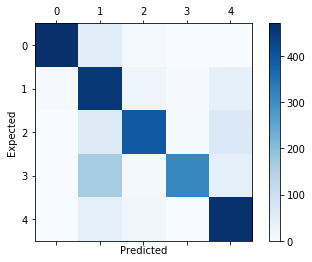

'[[125  10   0   0   0]\n [  3 430  45   0   0]\n [  0  17  78   0   0]\n [  0   5   0   0   0]\n [  0   4   0   0   2]]\nAccuracy for class BRA : [0.92592593]\nAccuracy for class BAM : [0.89958159]\nAccuracy for class BBI : [0.82105263]\nAccuracy for class BMA : [0.]\nAccuracy for class BIN : [0.33333333]\nOverall Accuracy : 0.8831710709318498'

In [38]:
y_pred_ohe = loaded_model.predict(X_test)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape
print(confusion_matrix)

for class_i in range(len(labels)) :
    indices = np.argwhere(y_test == class_i)
    sum = 0
    for index in indices:
        sum += (y_test[index] == y_pred_labels[index])
    if(len(indices) > 0) : mean = sum/len(indices)
    else : mean = "N/A"
    print("Accuracy for class", labels[class_i], ":", mean)

print("Overall Accuracy :", np.mean(y_test == y_pred_labels))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

'''[[125  10   0   0   0]
 [  3 430  45   0   0]
 [  0  17  78   0   0]
 [  0   5   0   0   0]
 [  0   4   0   0   2]]
Accuracy for class BRA : [0.92592593]
Accuracy for class BAM : [0.89958159]
Accuracy for class BBI : [0.82105263]
Accuracy for class BMA : [0.]
Accuracy for class BIN : [0.33333333]
Overall Accuracy : 0.8831710709318498'''

In [39]:
from sklearn.metrics import classification_report, zero_one_loss

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

zero1loss = zero_one_loss(y_true=y_test, y_pred=y_pred_labels)

2638/2638 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 3ms/step


In [40]:
print(classification_report(y_test, y_pred_bool))
print(zero1loss)

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94       528
         1.0       0.59      0.87      0.70       527
         2.0       0.88      0.75      0.81       528
         3.0       0.97      0.59      0.73       528
         4.0       0.76      0.88      0.82       527

    accuracy                           0.80      2638
   macro avg       0.84      0.80      0.80      2638
weighted avg       0.84      0.80      0.80      2638

0.20394238059135705


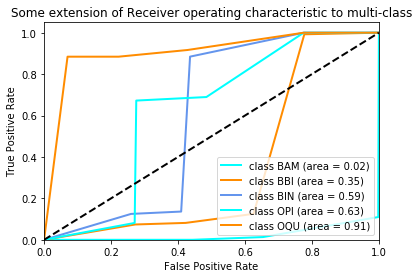

In [41]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_labels, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_labels.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [42]:
## Running the model

n_mfcc = config.buckets
max_len = config.max_len
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
file_path = "./prediction/nature_sc.wav"
big_wave, sr = librosa.load(file_path, mono=True, sr=None)
#print(wave.shape, sr)

classification = []

for sec_index in range( int(big_wave.shape[0] / sr) ) :
    start_sec = sec_index
    end_sec = sec_index + 1
    
    sec_to_trim = np.array( [ float(start_sec), float(end_sec) ] )
    print(sec_to_trim)
    sec_to_trim = np.ceil( sec_to_trim * sr )

    wave = big_wave[int(sec_to_trim[0]) : int(sec_to_trim[1])]
    print(wave)

    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    # Convert wav to MFCC
    prediction_data = wav2mfcc('./prediction/nature_sc.wav')
    prediction_data = mfcc
    print(prediction_data.shape)
    #print(wav2mfcc())
    # Reshape to 4 dimensions
    prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)
    #prediction_data = prediction_data.reshape(1, 20, config.max_len, channels)

    # Run the model on the inputted file
    predicted = loaded_model.predict(prediction_data)

    # Output the prediction values for each class
    print ('PREDICTED VALUES')
    labels_indices = range(len(labels))
    max_value = 0
    max_value_index = 0
    for index in labels_indices:
        print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
        if predicted[0,index] > max_value:
            max_value_index = index
            max_value = predicted[0,index]

    # Output the prediction
    if max_value < 0.5:
        print("GUESS: Nothing")
        classification.append( { "class" : "Nothing", "timestamp" : start_sec } )
    else:
        print('\n\nGUESS: ', labels[max_value_index])
        classification.append( { "class" : labels[max_value_index], "timestamp" : start_sec } )

print(classification)

[0. 1.]
[ 0.0000000e+00  1.5258789e-05  0.0000000e+00 ...  3.3020020e-02
  1.2680054e-02 -8.7432861e-03]
(128, 32)
PREDICTED VALUES

 BAM :  0.00070471

 BBI :  0.99113232

 BIN :  0.00807788

 OPI :  0.00000405

 OQU :  0.00008109


GUESS:  BBI
[1. 2.]
[-0.03717041 -0.05769348 -0.06455994 ...  0.01766968  0.01895142
  0.01779175]
(128, 32)
PREDICTED VALUES

 BAM :  0.00000040

 BBI :  0.83518916

 BIN :  0.16477688

 OPI :  0.00000004

 OQU :  0.00003356


GUESS:  BBI
[2. 3.]
[ 0.02345276  0.02101135  0.01712036 ... -0.01161194 -0.0141449
 -0.01431274]
(128, 32)
PREDICTED VALUES

 BAM :  0.00002334

 BBI :  0.98782665

 BIN :  0.01191832

 OPI :  0.00001624

 OQU :  0.00021548


GUESS:  BBI
[3. 4.]
[-0.01583862 -0.01066589 -0.00762939 ... -0.0377655  -0.03556824
 -0.02685547]
(128, 32)
PREDICTED VALUES

 BAM :  0.00000043

 BBI :  0.99999702

 BIN :  0.00000118

 OPI :  0.00000121

 OQU :  0.00000008


GUESS:  BBI
[4. 5.]
[-0.02836609 -0.02510071 -0.02012634 ...  0.0138855  -0.0038604

 BIN :  0.27507716

 OPI :  0.01843213

 OQU :  0.09263515


GUESS:  BBI
[{'class': 'BBI', 'timestamp': 0}, {'class': 'BBI', 'timestamp': 1}, {'class': 'BBI', 'timestamp': 2}, {'class': 'BBI', 'timestamp': 3}, {'class': 'BBI', 'timestamp': 4}, {'class': 'BBI', 'timestamp': 5}, {'class': 'BBI', 'timestamp': 6}, {'class': 'BBI', 'timestamp': 7}, {'class': 'BBI', 'timestamp': 8}, {'class': 'BIN', 'timestamp': 9}, {'class': 'BBI', 'timestamp': 10}, {'class': 'BIN', 'timestamp': 11}, {'class': 'Nothing', 'timestamp': 12}, {'class': 'BIN', 'timestamp': 13}, {'class': 'BAM', 'timestamp': 14}, {'class': 'BAM', 'timestamp': 15}, {'class': 'BAM', 'timestamp': 16}, {'class': 'BAM', 'timestamp': 17}, {'class': 'BAM', 'timestamp': 18}, {'class': 'BAM', 'timestamp': 19}, {'class': 'BAM', 'timestamp': 20}, {'class': 'BAM', 'timestamp': 21}, {'class': 'BAM', 'timestamp': 22}, {'class': 'BAM', 'timestamp': 23}, {'class': 'BAM', 'timestamp': 24}, {'class': 'Nothing', 'timestamp': 25}, {'class': 'Nothing